# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader
    #resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()
                                     ])
    
    #define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(data_dir,transform)
    
    #create and return DataLoader
    train_loader = DataLoader(dataset = train_dataset , batch_size=batch_size ,shuffle = True )
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [8]:
# Define function hyperparameters
batch_size = 64
img_size = 32
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

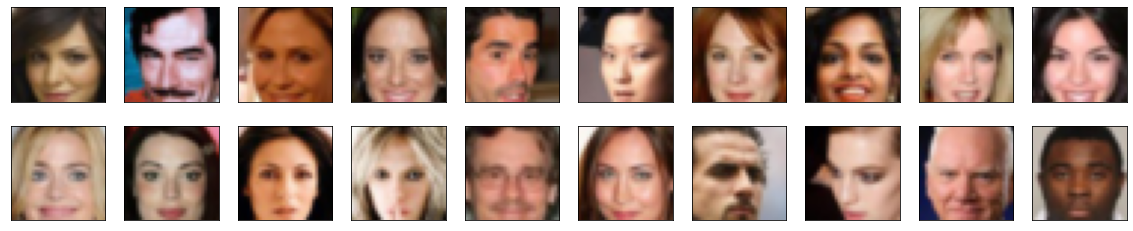

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min , max = feature_range
    x = x * (max - min) + min
    return x


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9451)
Max:  tensor(0.7412)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [23]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim = 32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        #32 x 32 input 
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)#No batch in first layer
        #16 x 16 
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        #8x8 
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4 x4 out
        
        #final fully connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
        #drop out layer 
        self.dropout = nn.Dropout(0.25)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activattion
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        #flatten 
        out = out.view(-1, self.conv_dim*4*4*4)
        
        #add dropout layer
        out = self.dropout(out)
        
        #final output layer
        out = self.fc(out)
        
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [25]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [27]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        
        # complete init function
        self.conv_dim = conv_dim
        
        
        #fully connected layer
        self.fc = nn.Linear(z_size,conv_dim *4*4*4)

        #drop out layer
        self.dropout = nn.Dropout(0.25)
        
        #transpose conv layers
        self.t_conv1 = deconv(conv_dim*4 , conv_dim*2 ,4)
        self.t_conv2 = deconv(conv_dim*2 , conv_dim , 4)
        self.t_conv3 = deconv(conv_dim , 3 , 4 ,batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        #fully connected + drop out + reshape
        out = self.fc(x)
        
        out = self.dropout(out) 
        
        out = out.view(-1 ,self.conv_dim*4 ,4 , 4)# (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/nobot/anaconda3/envs/envTest/lib/python3.8/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [47]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    init_gain=0.02 #std
    init_type='normal'
    mean = 0
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [49]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(


### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [55]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    #we are smoothing here to make discriminator numerically stable and ton generalize better
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels) #Squeeze here : we are squeezing any empty dimensions from the outputs
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels) #Squeeze here : we are squeezing any empty dimensions from the outputs
    return loss



## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [56]:
import torch.optim as optim

#params
lr = 0.0002
beta1 =0.5
beta2 = 0.999 #default value 
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [59]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            #resacle step -->reminder for myself important
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            
            d_optimizer.zero_grad()
            # 1. Train with real images
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # 2. Train with fake images
            
            # Generate fake images
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            # move to GPU if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #compute the discriminator losses on fake images
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            
            g_optimizer.zero_grad()
            
            # 1. Train with fake images and flipped labels
            
            # Generate fake images
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            # move to GPU if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [60]:
# set number of epochs 
n_epochs =60 


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   60] | d_loss: 0.3393 | g_loss: 2.6326
Epoch [    1/   60] | d_loss: 0.5198 | g_loss: 2.4130
Epoch [    1/   60] | d_loss: 0.4086 | g_loss: 2.5212
Epoch [    1/   60] | d_loss: 0.3339 | g_loss: 2.8888
Epoch [    1/   60] | d_loss: 0.5659 | g_loss: 1.9224
Epoch [    1/   60] | d_loss: 0.6730 | g_loss: 2.7292
Epoch [    1/   60] | d_loss: 0.6473 | g_loss: 2.3467
Epoch [    1/   60] | d_loss: 0.7411 | g_loss: 1.7787
Epoch [    1/   60] | d_loss: 0.8808 | g_loss: 1.4414
Epoch [    1/   60] | d_loss: 0.9412 | g_loss: 1.4756
Epoch [    1/   60] | d_loss: 0.7303 | g_loss: 1.2483
Epoch [    1/   60] | d_loss: 0.8917 | g_loss: 1.2007
Epoch [    1/   60] | d_loss: 0.8806 | g_loss: 1.6080
Epoch [    1/   60] | d_loss: 0.8501 | g_loss: 1.4844
Epoch [    1/   60] | d_loss: 0.9303 | g_loss: 1.3205
Epoch [    1/   60] | d_loss: 1.0111 | g_loss: 1.1532
Epoch [    1/   60] | d_loss: 0.9631 | g_loss: 1.9377
Epoch [    1/   60] | d_loss: 0.8988 | g_loss: 1.5034
Epoch [    1/   60] | d_loss

Epoch [    6/   60] | d_loss: 0.5241 | g_loss: 2.3174
Epoch [    6/   60] | d_loss: 1.2600 | g_loss: 3.0398
Epoch [    6/   60] | d_loss: 0.6677 | g_loss: 2.0096
Epoch [    6/   60] | d_loss: 0.7494 | g_loss: 1.5169
Epoch [    6/   60] | d_loss: 0.9117 | g_loss: 1.5039
Epoch [    6/   60] | d_loss: 0.5826 | g_loss: 2.7515
Epoch [    6/   60] | d_loss: 1.2116 | g_loss: 0.6350
Epoch [    6/   60] | d_loss: 0.8363 | g_loss: 1.4806
Epoch [    6/   60] | d_loss: 0.8473 | g_loss: 1.9603
Epoch [    6/   60] | d_loss: 0.7027 | g_loss: 2.0953
Epoch [    6/   60] | d_loss: 0.5734 | g_loss: 2.0810
Epoch [    6/   60] | d_loss: 0.8806 | g_loss: 1.7353
Epoch [    6/   60] | d_loss: 0.6589 | g_loss: 1.9348
Epoch [    6/   60] | d_loss: 0.7348 | g_loss: 2.2673
Epoch [    6/   60] | d_loss: 0.8745 | g_loss: 2.3864
Epoch [    6/   60] | d_loss: 0.8001 | g_loss: 2.4782
Epoch [    6/   60] | d_loss: 0.6470 | g_loss: 2.2703
Epoch [    6/   60] | d_loss: 0.5912 | g_loss: 1.8708
Epoch [    6/   60] | d_loss

Epoch [   11/   60] | d_loss: 0.7163 | g_loss: 2.0184
Epoch [   11/   60] | d_loss: 0.6985 | g_loss: 2.1810
Epoch [   11/   60] | d_loss: 0.4672 | g_loss: 3.6263
Epoch [   11/   60] | d_loss: 0.5256 | g_loss: 2.3677
Epoch [   11/   60] | d_loss: 0.5111 | g_loss: 2.2580
Epoch [   11/   60] | d_loss: 0.7638 | g_loss: 1.7440
Epoch [   11/   60] | d_loss: 0.6771 | g_loss: 2.0367
Epoch [   11/   60] | d_loss: 0.6610 | g_loss: 3.3374
Epoch [   11/   60] | d_loss: 0.5147 | g_loss: 1.8691
Epoch [   11/   60] | d_loss: 0.5213 | g_loss: 2.5819
Epoch [   11/   60] | d_loss: 0.6563 | g_loss: 2.3233
Epoch [   11/   60] | d_loss: 0.6413 | g_loss: 2.0494
Epoch [   11/   60] | d_loss: 0.6392 | g_loss: 2.5919
Epoch [   11/   60] | d_loss: 0.4275 | g_loss: 3.1023
Epoch [   11/   60] | d_loss: 0.5737 | g_loss: 2.0191
Epoch [   12/   60] | d_loss: 0.6334 | g_loss: 3.3447
Epoch [   12/   60] | d_loss: 0.5345 | g_loss: 1.8527
Epoch [   12/   60] | d_loss: 0.4696 | g_loss: 2.8115
Epoch [   12/   60] | d_loss

Epoch [   16/   60] | d_loss: 0.4001 | g_loss: 2.8562
Epoch [   16/   60] | d_loss: 1.0621 | g_loss: 2.2999
Epoch [   16/   60] | d_loss: 0.4808 | g_loss: 3.2556
Epoch [   16/   60] | d_loss: 0.5941 | g_loss: 3.4721
Epoch [   16/   60] | d_loss: 0.5590 | g_loss: 3.0512
Epoch [   16/   60] | d_loss: 0.6504 | g_loss: 2.4499
Epoch [   16/   60] | d_loss: 0.2984 | g_loss: 2.7444
Epoch [   16/   60] | d_loss: 0.3374 | g_loss: 3.6026
Epoch [   17/   60] | d_loss: 1.2156 | g_loss: 4.2473
Epoch [   17/   60] | d_loss: 0.2265 | g_loss: 3.5237
Epoch [   17/   60] | d_loss: 0.7629 | g_loss: 4.0166
Epoch [   17/   60] | d_loss: 0.9700 | g_loss: 2.0944
Epoch [   17/   60] | d_loss: 0.7370 | g_loss: 4.9047
Epoch [   17/   60] | d_loss: 0.7143 | g_loss: 3.8656
Epoch [   17/   60] | d_loss: 0.5623 | g_loss: 3.0493
Epoch [   17/   60] | d_loss: 0.3830 | g_loss: 2.0060
Epoch [   17/   60] | d_loss: 0.5379 | g_loss: 3.3652
Epoch [   17/   60] | d_loss: 0.5519 | g_loss: 2.4074
Epoch [   17/   60] | d_loss

Epoch [   21/   60] | d_loss: 0.4806 | g_loss: 2.6216
Epoch [   22/   60] | d_loss: 0.4782 | g_loss: 2.7738
Epoch [   22/   60] | d_loss: 0.3367 | g_loss: 2.8946
Epoch [   22/   60] | d_loss: 0.3557 | g_loss: 3.2914
Epoch [   22/   60] | d_loss: 0.3954 | g_loss: 3.4195
Epoch [   22/   60] | d_loss: 0.5107 | g_loss: 3.3758
Epoch [   22/   60] | d_loss: 0.5834 | g_loss: 2.3517
Epoch [   22/   60] | d_loss: 0.4421 | g_loss: 2.7556
Epoch [   22/   60] | d_loss: 0.4609 | g_loss: 3.5621
Epoch [   22/   60] | d_loss: 0.4333 | g_loss: 3.2298
Epoch [   22/   60] | d_loss: 0.1957 | g_loss: 3.6431
Epoch [   22/   60] | d_loss: 0.3951 | g_loss: 3.5206
Epoch [   22/   60] | d_loss: 0.6378 | g_loss: 3.0774
Epoch [   22/   60] | d_loss: 0.4248 | g_loss: 5.0167
Epoch [   22/   60] | d_loss: 0.4750 | g_loss: 4.3925
Epoch [   22/   60] | d_loss: 0.4608 | g_loss: 3.9542
Epoch [   22/   60] | d_loss: 0.5511 | g_loss: 2.1023
Epoch [   22/   60] | d_loss: 0.3438 | g_loss: 2.9670
Epoch [   22/   60] | d_loss

Epoch [   27/   60] | d_loss: 0.4293 | g_loss: 3.3434
Epoch [   27/   60] | d_loss: 0.2730 | g_loss: 3.3675
Epoch [   27/   60] | d_loss: 0.1325 | g_loss: 2.6995
Epoch [   27/   60] | d_loss: 0.1937 | g_loss: 3.1594
Epoch [   27/   60] | d_loss: 0.2433 | g_loss: 4.9376
Epoch [   27/   60] | d_loss: 0.3167 | g_loss: 4.2483
Epoch [   27/   60] | d_loss: 0.3119 | g_loss: 4.1851
Epoch [   27/   60] | d_loss: 0.3813 | g_loss: 3.4386
Epoch [   27/   60] | d_loss: 1.3384 | g_loss: 5.0445
Epoch [   27/   60] | d_loss: 0.2942 | g_loss: 3.4433
Epoch [   27/   60] | d_loss: 0.1243 | g_loss: 3.5869
Epoch [   27/   60] | d_loss: 0.4977 | g_loss: 3.1309
Epoch [   27/   60] | d_loss: 0.1762 | g_loss: 4.6642
Epoch [   27/   60] | d_loss: 1.0138 | g_loss: 3.5182
Epoch [   27/   60] | d_loss: 0.4848 | g_loss: 2.9089
Epoch [   27/   60] | d_loss: 0.3207 | g_loss: 2.9440
Epoch [   27/   60] | d_loss: 0.2010 | g_loss: 2.8918
Epoch [   27/   60] | d_loss: 0.3101 | g_loss: 4.7563
Epoch [   27/   60] | d_loss

Epoch [   32/   60] | d_loss: 0.3989 | g_loss: 3.7764
Epoch [   32/   60] | d_loss: 0.5000 | g_loss: 2.7912
Epoch [   32/   60] | d_loss: 0.2275 | g_loss: 4.4672
Epoch [   32/   60] | d_loss: 0.2794 | g_loss: 4.3157
Epoch [   32/   60] | d_loss: 0.4002 | g_loss: 2.9896
Epoch [   32/   60] | d_loss: 0.2834 | g_loss: 2.4773
Epoch [   32/   60] | d_loss: 0.4881 | g_loss: 3.4246
Epoch [   32/   60] | d_loss: 0.2594 | g_loss: 3.6043
Epoch [   32/   60] | d_loss: 0.3224 | g_loss: 4.7781
Epoch [   32/   60] | d_loss: 0.2575 | g_loss: 4.8820
Epoch [   32/   60] | d_loss: 0.3676 | g_loss: 3.1808
Epoch [   32/   60] | d_loss: 0.3498 | g_loss: 4.6607
Epoch [   32/   60] | d_loss: 2.6774 | g_loss: 0.9594
Epoch [   32/   60] | d_loss: 0.3301 | g_loss: 3.3548
Epoch [   32/   60] | d_loss: 0.2493 | g_loss: 3.9033
Epoch [   32/   60] | d_loss: 0.4266 | g_loss: 3.8929
Epoch [   33/   60] | d_loss: 0.5526 | g_loss: 1.8411
Epoch [   33/   60] | d_loss: 0.4008 | g_loss: 2.7799
Epoch [   33/   60] | d_loss

Epoch [   37/   60] | d_loss: 0.2348 | g_loss: 4.6350
Epoch [   37/   60] | d_loss: 0.3481 | g_loss: 4.3963
Epoch [   37/   60] | d_loss: 0.2450 | g_loss: 3.9888
Epoch [   37/   60] | d_loss: 0.2535 | g_loss: 4.6145
Epoch [   37/   60] | d_loss: 0.2203 | g_loss: 3.8385
Epoch [   37/   60] | d_loss: 0.1690 | g_loss: 4.2843
Epoch [   37/   60] | d_loss: 0.1966 | g_loss: 4.4834
Epoch [   37/   60] | d_loss: 10.7993 | g_loss: 4.2629
Epoch [   37/   60] | d_loss: 0.2320 | g_loss: 3.7643
Epoch [   38/   60] | d_loss: 0.3891 | g_loss: 2.6538
Epoch [   38/   60] | d_loss: 0.2341 | g_loss: 4.4100
Epoch [   38/   60] | d_loss: 0.2806 | g_loss: 5.0243
Epoch [   38/   60] | d_loss: 0.2481 | g_loss: 4.8988
Epoch [   38/   60] | d_loss: 0.2139 | g_loss: 3.2247
Epoch [   38/   60] | d_loss: 0.1806 | g_loss: 3.9269
Epoch [   38/   60] | d_loss: 0.1802 | g_loss: 5.8572
Epoch [   38/   60] | d_loss: 0.1169 | g_loss: 4.2002
Epoch [   38/   60] | d_loss: 0.2384 | g_loss: 4.3937
Epoch [   38/   60] | d_los

Epoch [   42/   60] | d_loss: 0.3785 | g_loss: 5.0413
Epoch [   42/   60] | d_loss: 0.3913 | g_loss: 5.2768
Epoch [   43/   60] | d_loss: 0.2374 | g_loss: 4.7545
Epoch [   43/   60] | d_loss: 0.1933 | g_loss: 4.5938
Epoch [   43/   60] | d_loss: 0.2365 | g_loss: 5.5463
Epoch [   43/   60] | d_loss: 0.1818 | g_loss: 5.3765
Epoch [   43/   60] | d_loss: 0.2115 | g_loss: 6.5655
Epoch [   43/   60] | d_loss: 0.0992 | g_loss: 4.4219
Epoch [   43/   60] | d_loss: 0.5090 | g_loss: 3.3748
Epoch [   43/   60] | d_loss: 0.1390 | g_loss: 4.6665
Epoch [   43/   60] | d_loss: 0.1464 | g_loss: 3.5127
Epoch [   43/   60] | d_loss: 0.2294 | g_loss: 3.1627
Epoch [   43/   60] | d_loss: 1.1810 | g_loss: 1.6490
Epoch [   43/   60] | d_loss: 0.2701 | g_loss: 4.3191
Epoch [   43/   60] | d_loss: 0.2231 | g_loss: 5.2214
Epoch [   43/   60] | d_loss: 0.2768 | g_loss: 3.8228
Epoch [   43/   60] | d_loss: 0.3353 | g_loss: 5.3228
Epoch [   43/   60] | d_loss: 0.1280 | g_loss: 5.8961
Epoch [   43/   60] | d_loss

Epoch [   48/   60] | d_loss: 0.1423 | g_loss: 5.2211
Epoch [   48/   60] | d_loss: 0.1496 | g_loss: 6.0358
Epoch [   48/   60] | d_loss: 0.2916 | g_loss: 5.6467
Epoch [   48/   60] | d_loss: 0.1589 | g_loss: 4.7647
Epoch [   48/   60] | d_loss: 0.2873 | g_loss: 3.2636
Epoch [   48/   60] | d_loss: 0.1017 | g_loss: 4.1824
Epoch [   48/   60] | d_loss: 0.1455 | g_loss: 4.3422
Epoch [   48/   60] | d_loss: 0.0663 | g_loss: 4.8891
Epoch [   48/   60] | d_loss: 0.1192 | g_loss: 6.7166
Epoch [   48/   60] | d_loss: 0.1476 | g_loss: 5.0632
Epoch [   48/   60] | d_loss: 0.2211 | g_loss: 5.5826
Epoch [   48/   60] | d_loss: 0.2122 | g_loss: 4.8948
Epoch [   48/   60] | d_loss: 0.4178 | g_loss: 2.9730
Epoch [   48/   60] | d_loss: 0.2995 | g_loss: 3.6742
Epoch [   48/   60] | d_loss: 0.2020 | g_loss: 5.4733
Epoch [   48/   60] | d_loss: 0.3959 | g_loss: 4.1803
Epoch [   48/   60] | d_loss: 0.1464 | g_loss: 3.5969
Epoch [   48/   60] | d_loss: 0.1412 | g_loss: 6.4957
Epoch [   48/   60] | d_loss

Epoch [   53/   60] | d_loss: 0.1878 | g_loss: 5.2184
Epoch [   53/   60] | d_loss: 0.3187 | g_loss: 5.5995
Epoch [   53/   60] | d_loss: 0.0929 | g_loss: 4.9177
Epoch [   53/   60] | d_loss: 0.2190 | g_loss: 4.7645
Epoch [   53/   60] | d_loss: 0.1936 | g_loss: 4.8568
Epoch [   53/   60] | d_loss: 0.1890 | g_loss: 4.0029
Epoch [   53/   60] | d_loss: 0.0788 | g_loss: 5.6896
Epoch [   53/   60] | d_loss: 0.9514 | g_loss: 2.6166
Epoch [   53/   60] | d_loss: 0.3560 | g_loss: 4.9105
Epoch [   53/   60] | d_loss: 0.1701 | g_loss: 4.5885
Epoch [   53/   60] | d_loss: 0.1894 | g_loss: 4.8119
Epoch [   53/   60] | d_loss: 0.2533 | g_loss: 4.0710
Epoch [   53/   60] | d_loss: 4.9064 | g_loss: 10.8495
Epoch [   53/   60] | d_loss: 0.4942 | g_loss: 3.4264
Epoch [   53/   60] | d_loss: 0.1570 | g_loss: 6.8859
Epoch [   53/   60] | d_loss: 0.1670 | g_loss: 5.7336
Epoch [   53/   60] | d_loss: 0.1533 | g_loss: 5.6619
Epoch [   54/   60] | d_loss: 0.1383 | g_loss: 5.4415
Epoch [   54/   60] | d_los

Epoch [   58/   60] | d_loss: 0.0895 | g_loss: 4.3724
Epoch [   58/   60] | d_loss: 0.2147 | g_loss: 5.6977
Epoch [   58/   60] | d_loss: 0.0543 | g_loss: 5.2130
Epoch [   58/   60] | d_loss: 0.1840 | g_loss: 6.1789
Epoch [   58/   60] | d_loss: 0.1742 | g_loss: 5.9614
Epoch [   58/   60] | d_loss: 0.2019 | g_loss: 5.6604
Epoch [   58/   60] | d_loss: 0.0538 | g_loss: 7.3438
Epoch [   58/   60] | d_loss: 0.1974 | g_loss: 4.6858
Epoch [   58/   60] | d_loss: 0.1798 | g_loss: 4.3514
Epoch [   58/   60] | d_loss: 0.1632 | g_loss: 4.3112
Epoch [   59/   60] | d_loss: 0.1851 | g_loss: 6.0652
Epoch [   59/   60] | d_loss: 0.2500 | g_loss: 6.2016
Epoch [   59/   60] | d_loss: 0.1221 | g_loss: 5.6838
Epoch [   59/   60] | d_loss: 0.3721 | g_loss: 4.0792
Epoch [   59/   60] | d_loss: 0.2565 | g_loss: 7.5112
Epoch [   59/   60] | d_loss: 0.2207 | g_loss: 3.5370
Epoch [   59/   60] | d_loss: 0.1568 | g_loss: 6.6691
Epoch [   59/   60] | d_loss: 0.1325 | g_loss: 4.6601
Epoch [   59/   60] | d_loss

/home/nobot/anaconda3/envs/envTest/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

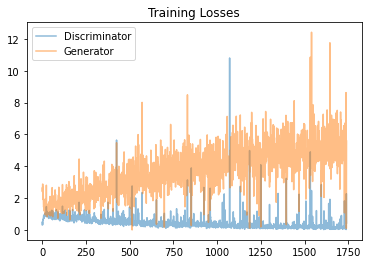

In [61]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [62]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [63]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

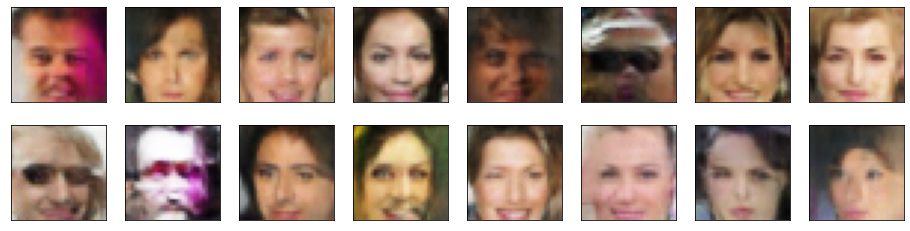

In [64]:
_ = view_samples(-1, samples)

## Future work :
I want to improve the model so that generator loss would be near from the discriminator loss as they are getting far from nearly epoch 30